In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from frouros.callbacks.batch import PermutationTestDistanceBased
from frouros.detectors.data_drift import MMD

# Multivariate detector

The following example shows the use of MMD {cite:p}`JMLR:v13:gretton12a` multivariate detector for two different classes with two features each.

In [2]:
seed = 31
np.random.seed(seed=31)

X, y = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=2,
    random_state=seed,
)

Data is split in 70% train and the remaining 30% for test.

In [3]:
idxs = np.arange(X.shape[0])
np.random.shuffle(idxs)
X, y = X[idxs], y[idxs]

idx_split = int(X.shape[0] * 0.7)
X_train, y_train, X_test, y_test = X[:idx_split], y[:idx_split], X[idx_split:], y[idx_split:]

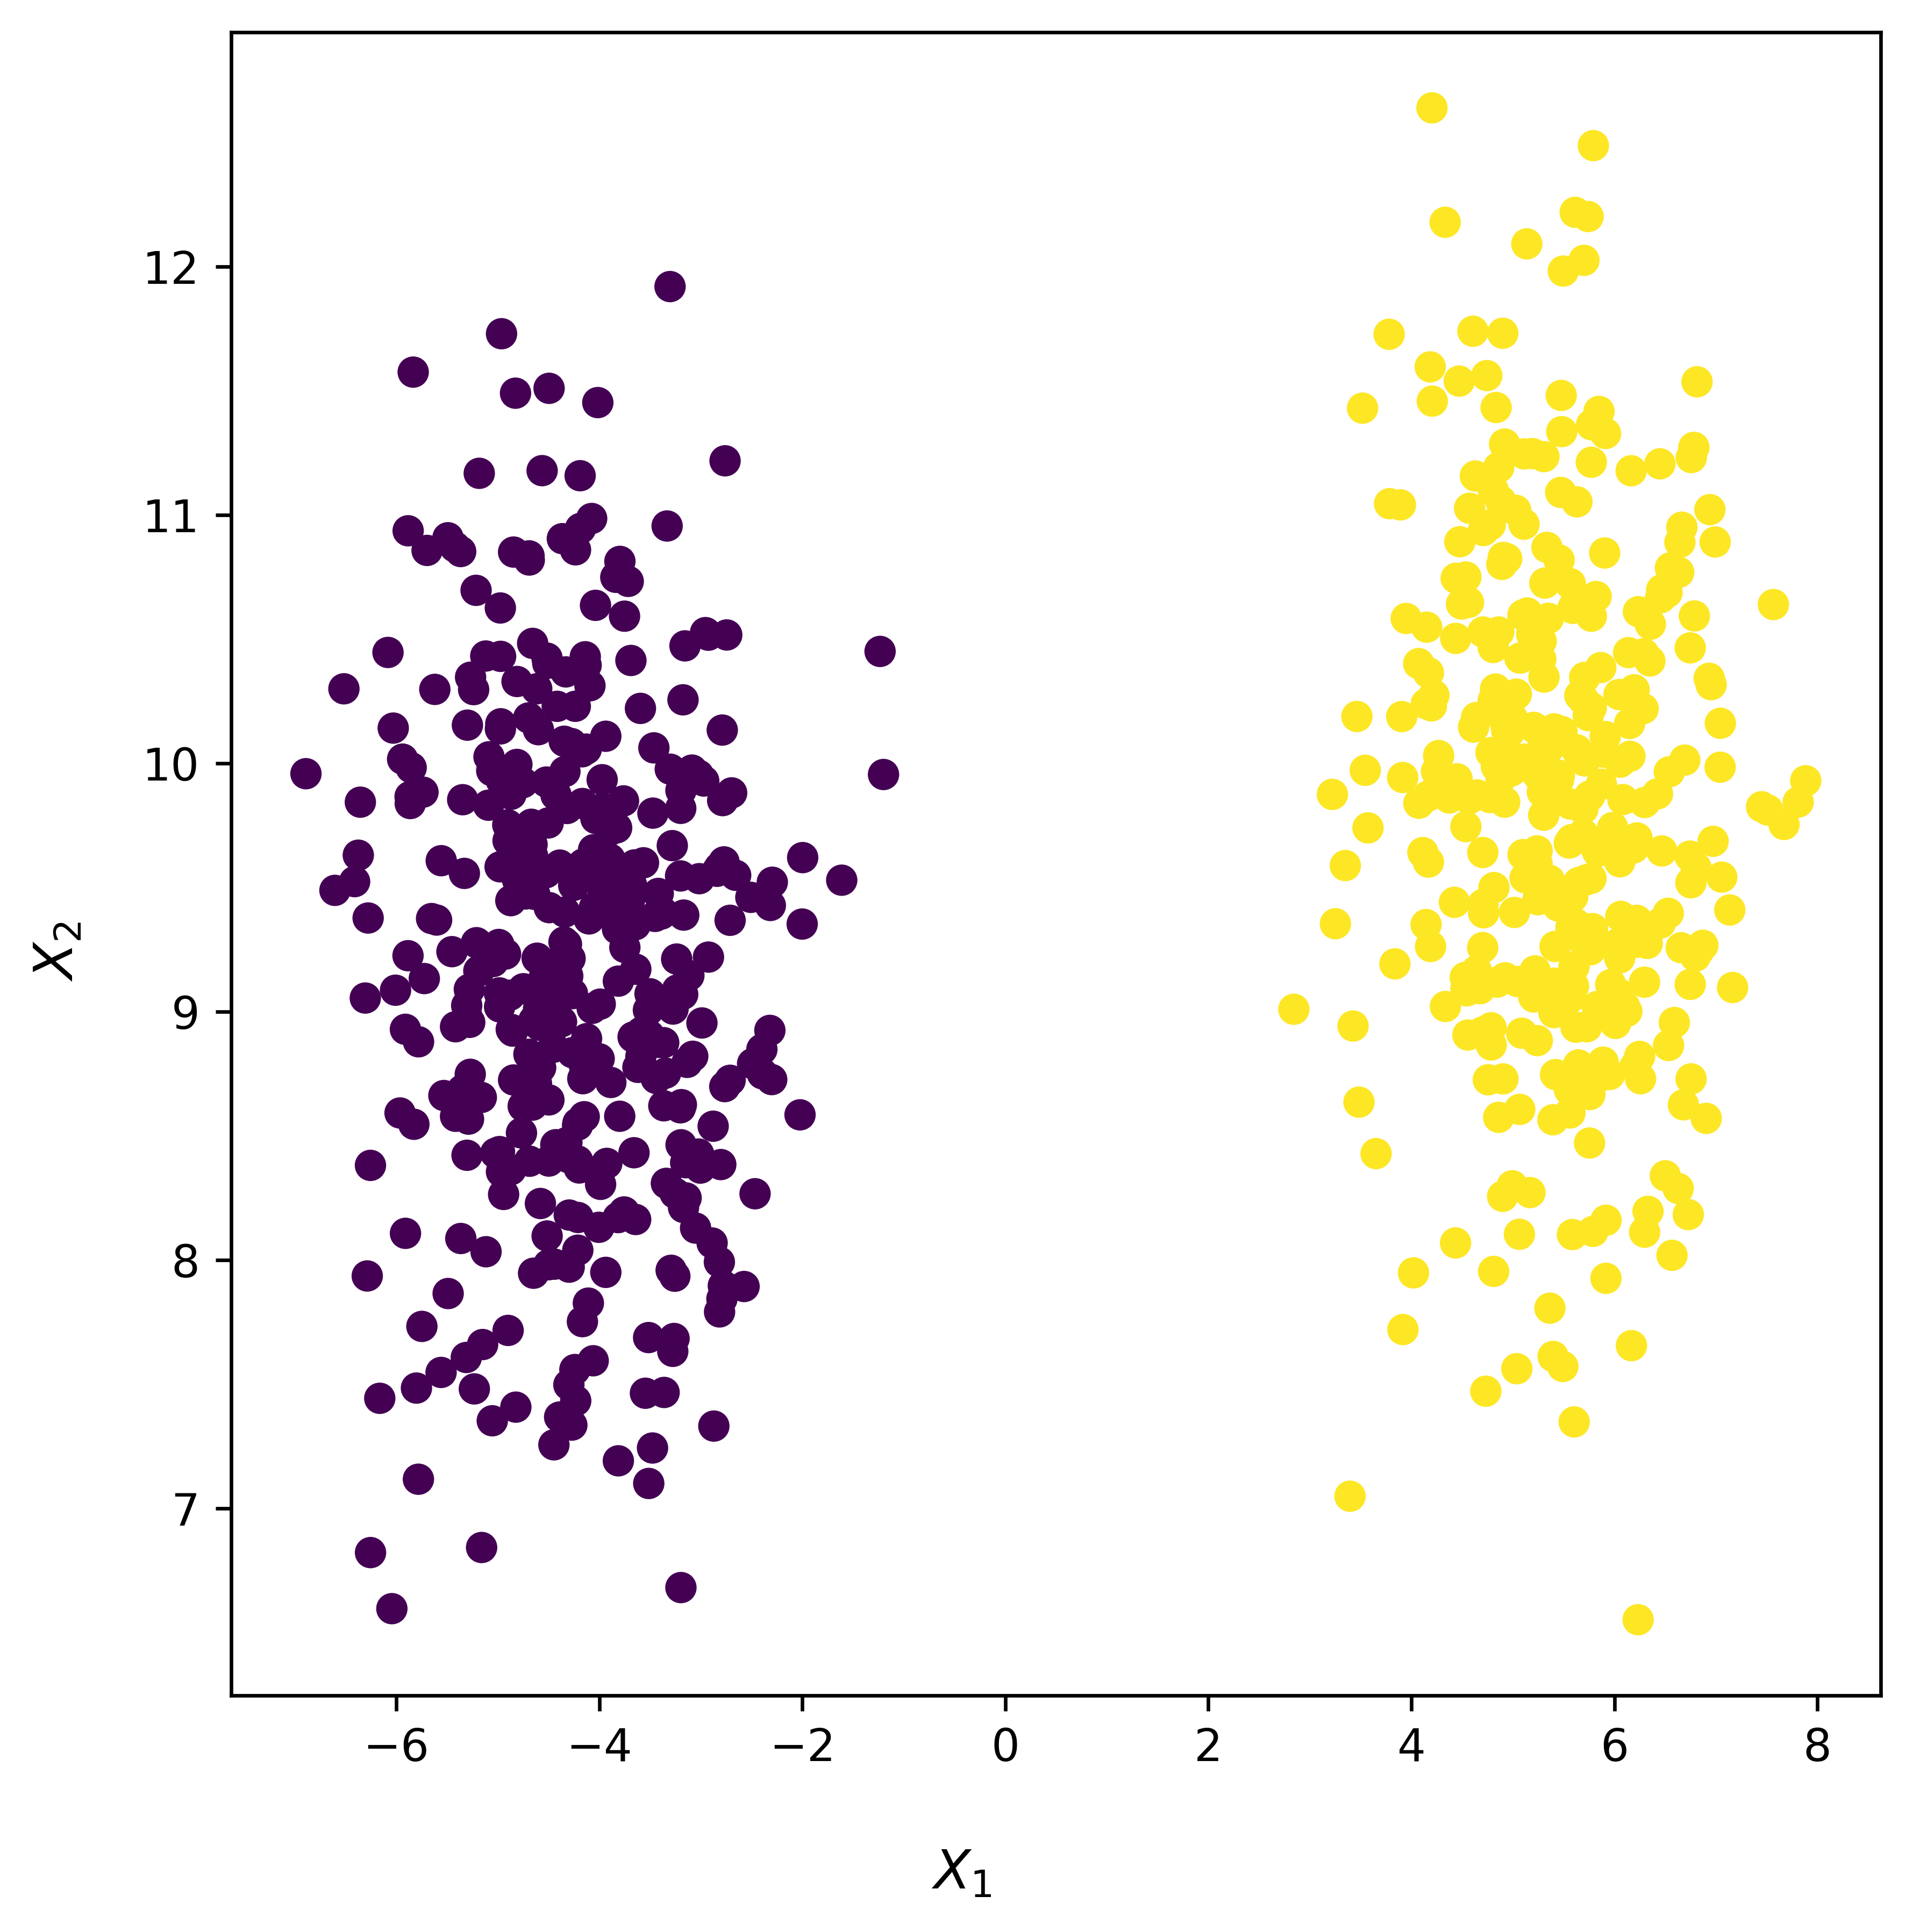

In [4]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
ax.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train)
fig.supxlabel("$X_{1}$")
fig.supylabel("$X_{2}$")
fig.tight_layout()
plt.show()

The significance level will be $\alpha = 0.01$.

In [5]:
alpha = 0.01

Create and fit a MMD detector using the training dataset.

In [6]:
detector = MMD(
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=1000,
            random_state=31,
            num_jobs=-1,
            method="exact",
            name="permutation_test",
            verbose=True,
        ),
    ],
)
_ = detector.fit(X=X_train)

Fitting a decision tree with the training/reference dataset.

In [7]:
model = DecisionTreeClassifier(random_state=seed)
model.fit(X=X_train, y=y_train)

DecisionTreeClassifier(random_state=31)

In addition to obtaining the predictions for the test data by calling the predict method, the detector compares the reference data with test data to determine if drift is occurring.

In [8]:
y_pred = model.predict(X=X_test)
_, callback_logs = detector.compare(X=X_test)
p_value = callback_logs["permutation_test"]["p_value"]
print(f"p-value: {round(p_value, 4)}")
if p_value <= alpha:
    print("Data drift detected")
else:
    print("No data drift detected")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")

100%|██████████| 1000/1000 [00:01<00:00, 812.45it/s]


p-value: 0.2707
No data drift detected
Accuracy: 1.0


As the above results show, no data drift was detected. Therefore, we can simulate data drift by applying some noise to the test data, as shown below:

In [9]:
X_test_noise = X_test.copy()
X_test_noise += np.random.normal(   # Add noise to features
    loc=0,
    scale=X_test_noise.std(axis=0),
    size=X_test_noise.shape,
)

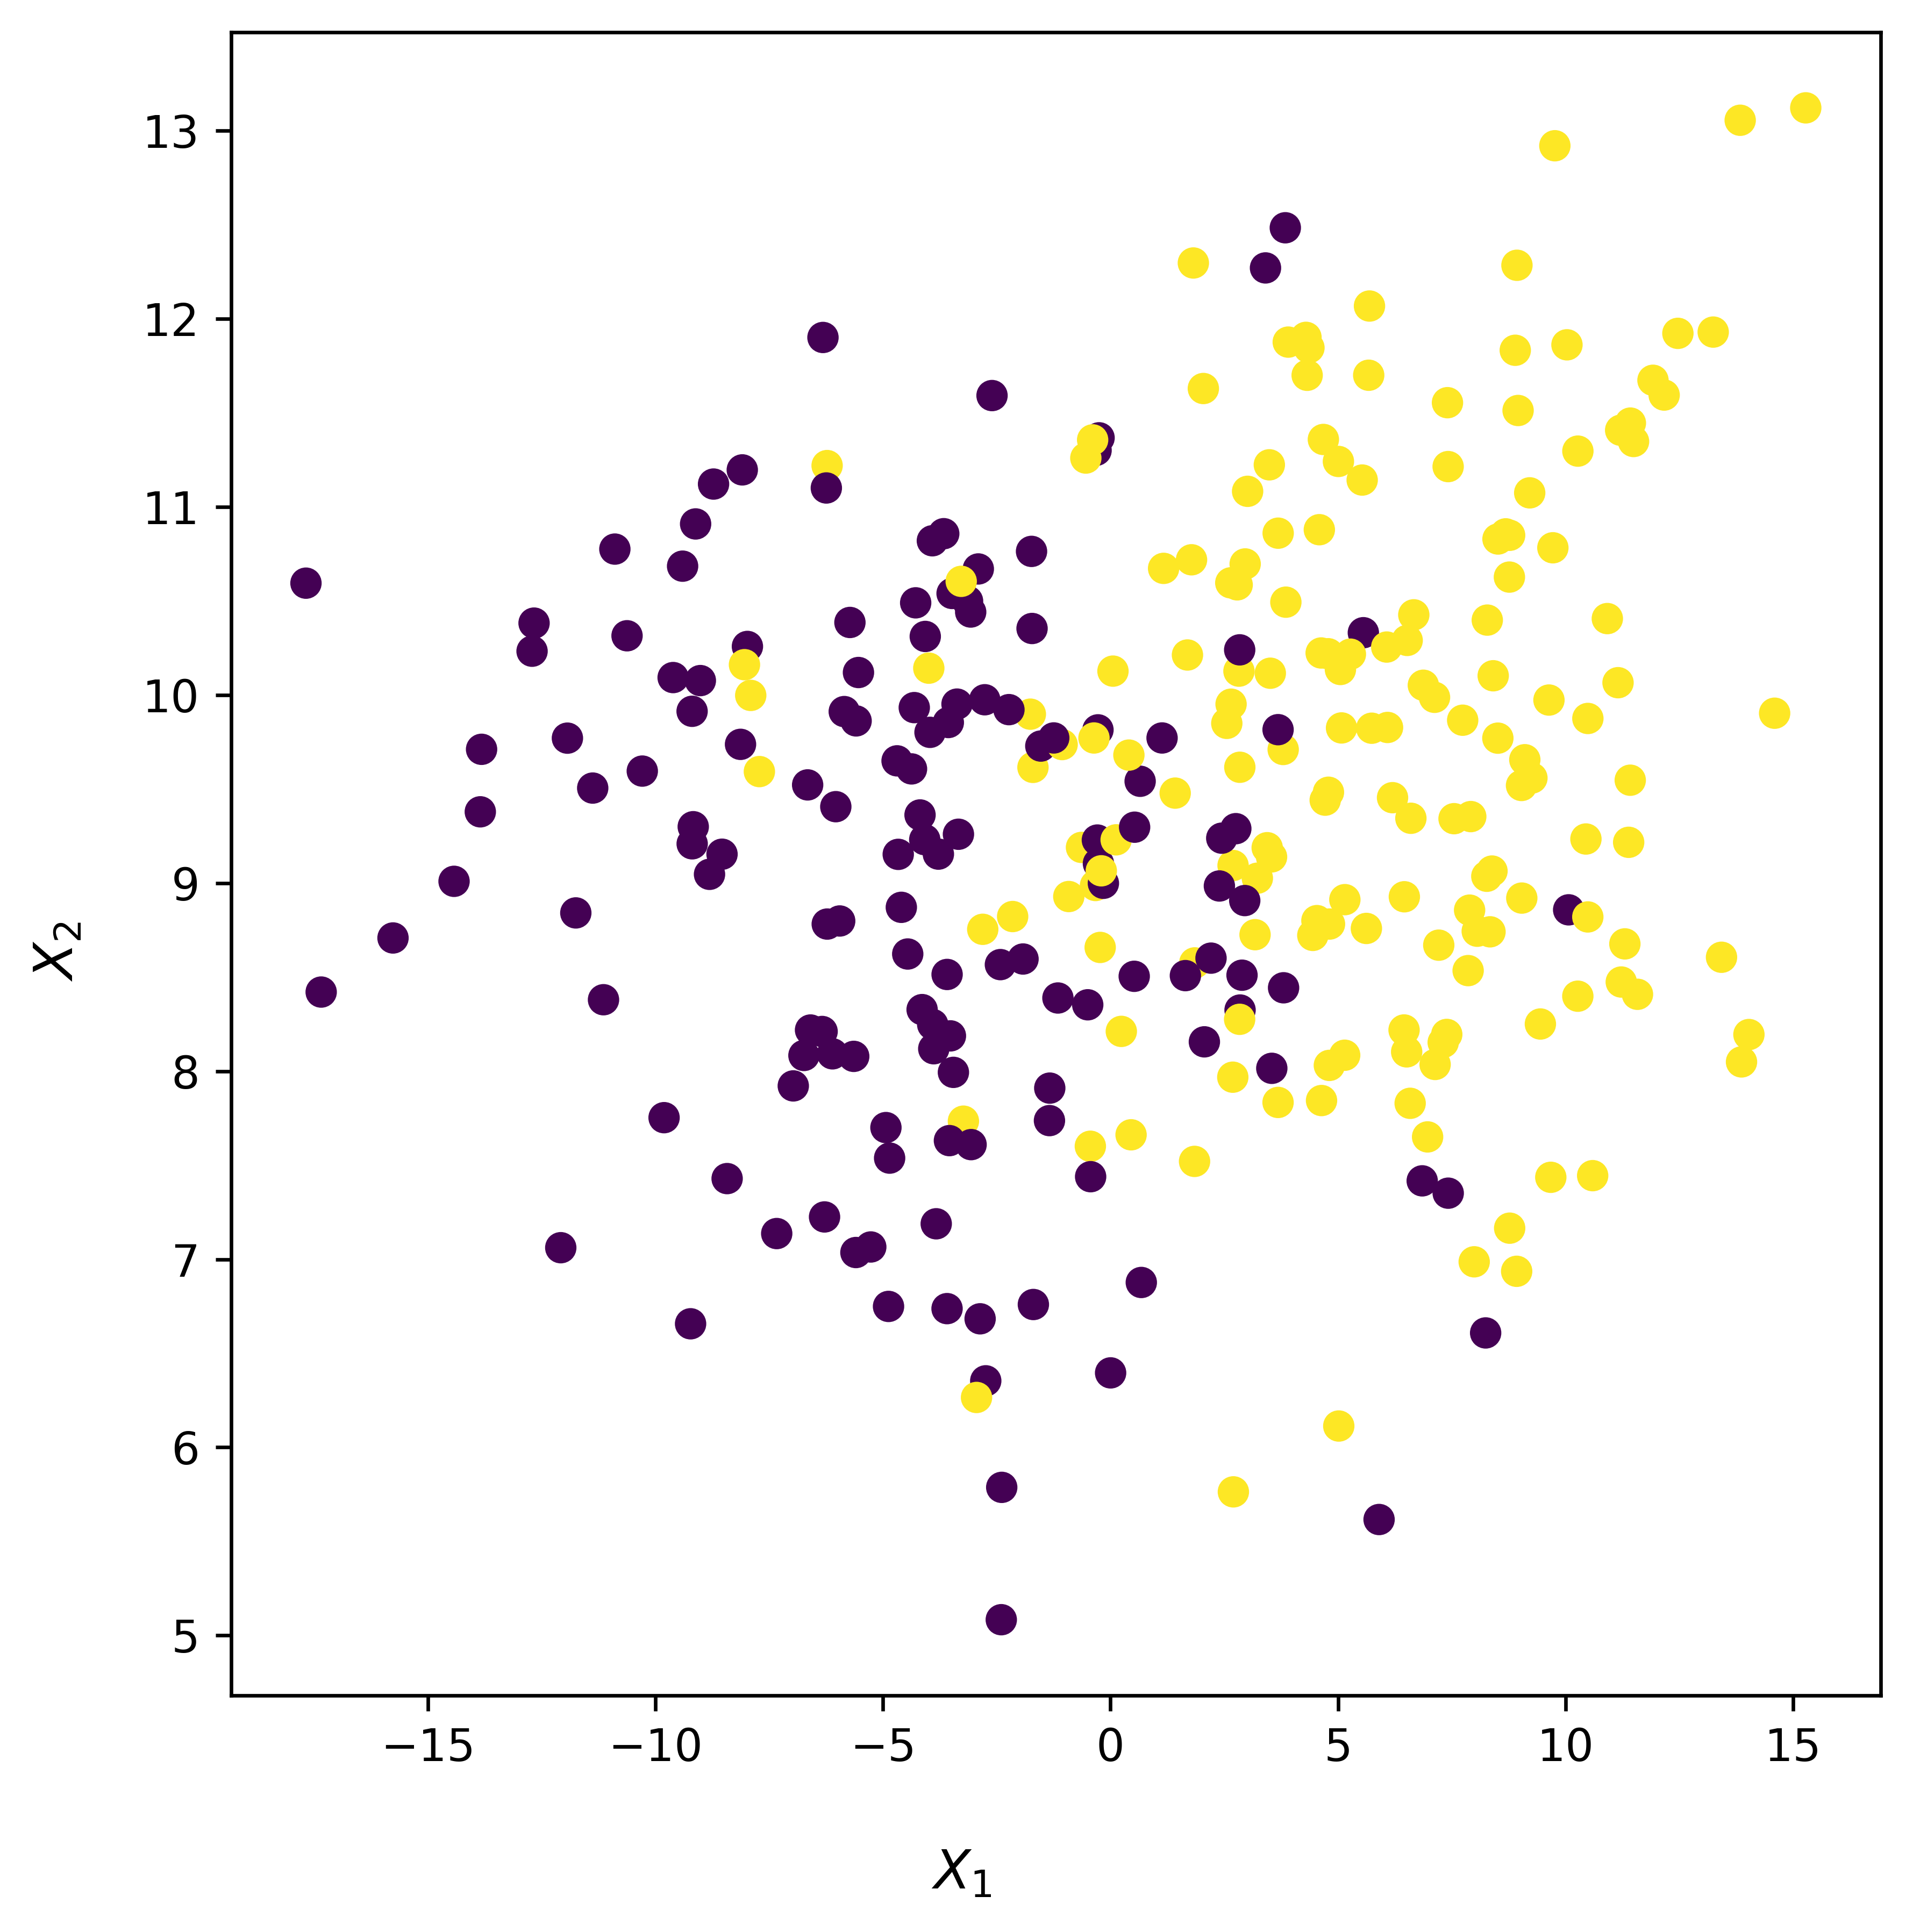

In [10]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
ax.scatter(X_test_noise[:, 0], X_test_noise[:, 1], marker="o", c=y_test)
fig.supxlabel("$X_{1}$")
fig.supylabel("$X_{2}$")
fig.tight_layout()
plt.show()

In [11]:
y_pred = model.predict(X=X_test_noise)
_, callback_logs = detector.compare(X=X_test_noise)
p_value = callback_logs["permutation_test"]["p_value"]
print(f"p-value: {round(p_value, 4)}")
if p_value <= alpha:
    print("Data drift detected")
else:
    print("No data drift detected")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")

100%|██████████| 1000/1000 [00:01<00:00, 839.71it/s]


p-value: 0.001
Data drift detected
Accuracy: 0.8367


Data drift has been detected and the model's performance has been affected by significantly lowering the accuracy value.

```{bibliography}
:filter: docname in docnames
```